# New York taxis trips

This homework is about New York taxi trips. Here is something from [Todd Schneider](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/):

> The New York City Taxi & Limousine Commission has released a  detailed historical dataset covering over 1 billion individual taxi trips in the city from January 2009 through December 2019. 
Taken as a whole, the detailed trip-level data is more than just a vast list of taxi pickup and drop off coordinates: it's a story of a City. 
How bad is the rush hour traffic from Midtown to JFK? 
Where does the Bridge and Tunnel crowd hang out on Saturday nights?
What time do investment bankers get to work? How has Uber changed the landscape for taxis?
The dataset addresses all of these questions and many more.

The NY taxi trips dataset has been plowed by series of distinguished data scientists.
The dataset is available from on Amazon S3 (Amazon's cloud storage service).
The link for each file has the following form:

    https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{year}-{month}.csv

There is one CSV file for each NY taxi service (`yellow`, `green`, `fhv`) and each calendar month (replacing `{year}` and `{month}` by the desired ones).
Each file is moderately large, a few gigabytes. 
The full dataset is relatively large if it has to be handled on a laptop (several hundred gigabytes).

You will focus on the `yellow` taxi service and a pair of months, from year 2015 and from year 2018. 
Between those two years, for hire vehicles services have taken off and carved a huge marketshare.

Whatever the framework you use, `CSV` files prove hard to handle. 
After downloading the appropriate files (this takes time, but this is routine), a first step will consist in converting the csv files into a more Spark friendly format such as `parquet`.

Saving into one of those formats require decisions about bucketing, partitioning and so on. Such decisions influence performance. It is your call.
Many people have been working on this dataset, to cite but a few:


- [1 billion trips with a vengeance](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/)
- [1 billion trips with R and SQL ](http://freerangestats.info/blog/2019/12/22/nyc-taxis-sql)
- [1 billion trips with redshift](https://tech.marksblogg.com/billion-nyc-taxi-rides-redshift.html)
- [nyc-taxi](https://github.com/fmaletski/nyc-taxi-map)

Depending on your internet connection, **download the files** corresponding to **"yellow" taxis** for the years 2015 and 2018. Download **at least one month** (the same) for 2015 and 2018, if you can download all of them.

**Hint.** The 12 csv for 2015 are about 23GB in total, but the corresponding parquet file, if you can create it for all 12 months, is only about 3GB.

You **might** need the following stuff in order to work with GPS coordinates and to plot things easily.

In [1]:
!pip install geojson geopandas plotly geopy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install ipyleaflet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


For this homework **we will let you decide on the tools to use** (expected for Spark) and to **find out information all by yourself** (but don't hesitate to ask questions on the `slack` channel).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import timeit
import seaborn as sns


# spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import col
import pyspark.sql.functions as fn
from pyspark.sql.catalog import Catalog
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, StringType


# Loading data as parquet files

We want to organize the data on a per year and per service basis. 
We want to end up with one `parquet` file for each year and each taxi service, since parquet is much better than CSV files.

**Hint.** Depending on your internet connection and your laptop, you can use only the "yellow" service and use one month of 2015 and 2018

CSV files can contain corrupted lines. You may have to work in order to perform ETL (Extract-Transform-Load) in order obtain a properly typed data frame.

You are invited to proceed as follows:

1. Try to read the CSV file without imposing a schema. 
1. Inspect the inferred schema. Do you agree with Spark's typing decision?
1. Eventually correct the schema and read again the data
1. Save the data into parquet files
1. In the rest of your work, **you will only use the parquet files you created**, not the csv files (don't forget to choose a partitioning column and a number of partitions when creating the parquet files).

**Hint.** Don't forget to ask `Spark` to use all the memory and ressources from your computer.

**Hint.** Don't foreget that you should specify a partitioning column and a number of partitions when creating the parquet files.

**Hint.** Note that the schemas of the 2015 and 2018 data are different...

**Hint.** When working on this, ask you and answer to the following questions:

1. What is the `StorageLevel` of the dataframe after reading the csv files?
1. What is the number of partitions of the dataframe? 
1. Is it possible to tune this number at loading time? 
1. Why would we want to modify the number of partitions when creating the parquet files?

In [4]:
conf = SparkConf().setAppName("Spark SQL Illustrations")
sc = SparkContext(conf=conf)

spark = (SparkSession
    .builder
    .appName("Spark SQL")
    .getOrCreate()
)

spark.conf.set("spark.executor.memory","7g")

In [5]:
from pathlib import Path
path = Path('./ytd_2015-01.parquet')
if not path.exists():
    df = spark.read\
                 .format('csv')\
                 .option("header", "true")\
                 .option("mode", "FAILFAST")\
                 .option("inferSchema", "true")\
                 .option("sep", ",")\
                 .load(os.path.join('.','yellow_tripdata_2015-01.csv'))
    df.write.parquet('./ytd_2015-01.parquet')
    
path = Path('./ytd_2018-01.parquet')
if not path.exists():
    df = spark.read\
                 .format('csv')\
                 .option("header", "true")\
                 .option("mode", "FAILFAST")\
                 .option("inferSchema", "true")\
                 .option("sep", ",")\
                 .load(os.path.join('.','yellow_tripdata_2018-01.csv'))
    df.write.parquet('./ytd_2018-01.parquet')


In [6]:

#df_2015.write.parquet('./ytd_2015-01.parquet')
df_2015 = spark.read.parquet('./ytd_2015-01.parquet')
df_2015.printSchema()
df_2018 = spark.read.parquet('./ytd_2018-01.parquet')
df_2018.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropof

# Investigate (at least) one month of data in 2015

From now on, you will be using **the parquet files you created for 2015**.

We shall visualize several features of taxi traffic during one calendar month
in 2015 and the same calendar month in 2018.

**Hint.** In order to build appealing graphics, you may stick to `matplotlib + seaborn`, you can use also
`plotly`, which is used a lot to build interactive graphics, but you can use whatever you want.

The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattan and Verazzano bridge.

In [7]:
long_min = -74.10
long_max = -73.70
lat_min = 40.58
lat_max = 40.90

1. Using these boundaries, **filter the 2015 data** (using pickup and dropoff longitude and latitude) and count the number of trips for each value of `passenger_count` and make a plot of that.

In [8]:
df15filt = df_2015.where("pickup_longitude > -74.10 AND pickup_longitude < -73.10")\
        .where("pickup_latitude > 40.58 AND pickup_latitude < 40.90")\
        .where("dropoff_longitude > -74.10 AND dropoff_longitude < -73.10")\
        .where("dropoff_latitude > 40.58 AND dropoff_latitude < 40.90")

df15filt.groupby('passenger_count').count().show()


+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|8768638|
|              6| 450060|
|              3| 517675|
|              5| 690566|
|              9|      6|
|              4| 247732|
|              8|      7|
|              7|      7|
|              2|1773138|
|              0|   6112|
+---------------+-------+



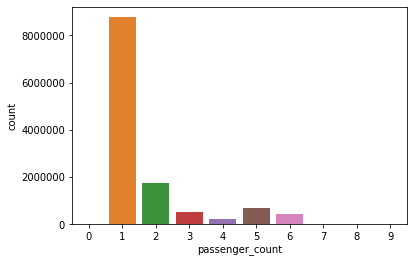

In [9]:
g = sns.barplot(x = 'passenger_count',y = 'count',data = df15filt.groupby('passenger_count').count().toPandas())

Trips with $0$ or larger than $7$ passengers are pretty rare.
We suspect these to be outliers. 
We need to explore these trips further in order order to understand what might be wrong
with them

1. What's special with trips with zero passengers?
1. What's special with trips with more than $6$ passengers?
1. What is the largest distance travelled during this month? Is it the first taxi on the moon?
1. Plot the distribution of the `trip_distance` (using an histogram for instance) during year 2015. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

In [10]:
#trips with zero passenger should not exist on a taxi traffic database
#trips with more than 6 passengers are special because an usual taxi car can only fit up to 5 people (if we count the driver).
df15filt.select('trip_distance').orderBy(df15filt.trip_distance.desc()).limit(10).show()

+-------------+
|trip_distance|
+-------------+
| 1.54200045E7|
|    1.23318E7|
|        1.2E7|
| 1.18000017E7|
| 1.18000006E7|
| 1.18000004E7|
|    8000016.5|
|    8000010.0|
|    7468004.3|
|    5000000.0|
+-------------+



In [11]:
df15trip1 =df15filt.select('trip_distance').where('trip_distance > 0 AND trip_distance < 2')
df15trip2 =df15filt.select('trip_distance').where('trip_distance >= 2 AND trip_distance < 30')
#due to lack of memory I'm doing to work with trips distance > 0 and < 2 and then look at the rest of the data.

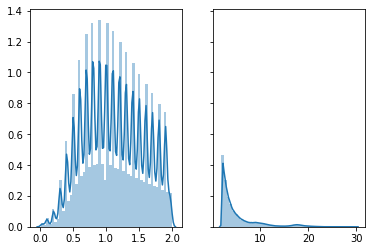

In [12]:
fig1, axes1 = plt.subplots(1,2, sharey = True)

sns.distplot(df15trip1.toPandas() , ax = axes1[0])
sns.distplot(df15trip2.toPandas() , ax = axes1[1])

Let's look at what Spark does for these computations

1. Use the `explain` method or have a look at the [Spark UI](http://localhost:4040/SQL/) to analyze the job. You should be able to assess 
    - Parsed Logical Plan
    - Analyzed Logical Plan
    - Optimized Logical Plan
    - Physical Plan
1. Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any. How would a RDBMS proceed with such a query?
1. How does the physical plan differ from the Optimized Logical Plan? What are the keywords you would not expects in a RDBMS? What is their meaning? 
1. Inspect the stages on [Spark UI](http://localhost:4040/stages/stage). How many *stages* are necessary to complete the Spark job? What are the roles of `HashAggregate` and `Exchange hashpartitioning`?
1. Does the physical plan perform `shuffle` operations? If yes how many?
1. What are tasks with respect to stages (in Spark language)? How many tasks are your stages made of?

In [13]:
df15trip1.explain()

== Physical Plan ==
*(1) Project [trip_distance#4]
+- *(1) Filter ((((((((((((((isnotnull(dropoff_latitude#10) && isnotnull(pickup_longitude#5)) && isnotnull(pickup_latitude#6)) && isnotnull(trip_distance#4)) && isnotnull(dropoff_longitude#9)) && (pickup_longitude#5 > -74.1)) && (pickup_longitude#5 < -73.1)) && (pickup_latitude#6 > 40.58)) && (pickup_latitude#6 < 40.9)) && (dropoff_longitude#9 > -74.1)) && (dropoff_longitude#9 < -73.1)) && (dropoff_latitude#10 > 40.58)) && (dropoff_latitude#10 < 40.9)) && (trip_distance#4 > 0.0)) && (trip_distance#4 < 2.0))
   +- *(1) FileScan parquet [trip_distance#4,pickup_longitude#5,pickup_latitude#6,dropoff_longitude#9,dropoff_latitude#10] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/opt/polynote/notebooks/ytd_2015-01.parquet], PartitionFilters: [], PushedFilters: [IsNotNull(dropoff_latitude), IsNotNull(pickup_longitude), IsNotNull(pickup_latitude), IsNotNull(..., ReadSchema: struct<trip_distance:double,pickup_longitude:double

Now, compute the following and produce relevant plots:

1. Break down the trip distance distribution for each day of week
1. Count the number of distinct pickup location
1. Compute and display tips and profits as a function of the pickup location

# Investigate one month of trips data in 2015 and 2018

 Consider one month of trips data from `yellow` taxis for each year

1. Filter and cache/persist the result

## Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

1. The number of pickups
1. The average fare
1. The average trip duration
1. Plot the average number of ongoing trips

In [34]:
df_2015.select("tpep_pickup_datetime").show()

+--------------------+
|tpep_pickup_datetime|
+--------------------+
| 2015-01-13 11:46:19|
| 2015-01-13 11:46:19|
| 2015-01-13 11:46:19|
| 2015-01-13 11:46:20|
| 2015-01-13 11:46:20|
| 2015-01-13 11:46:20|
| 2015-01-13 11:46:21|
| 2015-01-13 11:46:21|
| 2015-01-13 11:46:21|
| 2015-01-13 11:46:21|
| 2015-01-05 00:27:13|
| 2015-01-13 11:46:21|
| 2015-01-11 19:04:03|
| 2015-01-11 19:04:04|
| 2015-01-11 19:04:04|
| 2015-01-11 19:04:04|
| 2015-01-11 19:04:04|
| 2015-01-11 19:04:04|
| 2015-01-11 19:04:04|
| 2015-01-11 19:04:05|
+--------------------+
only showing top 20 rows



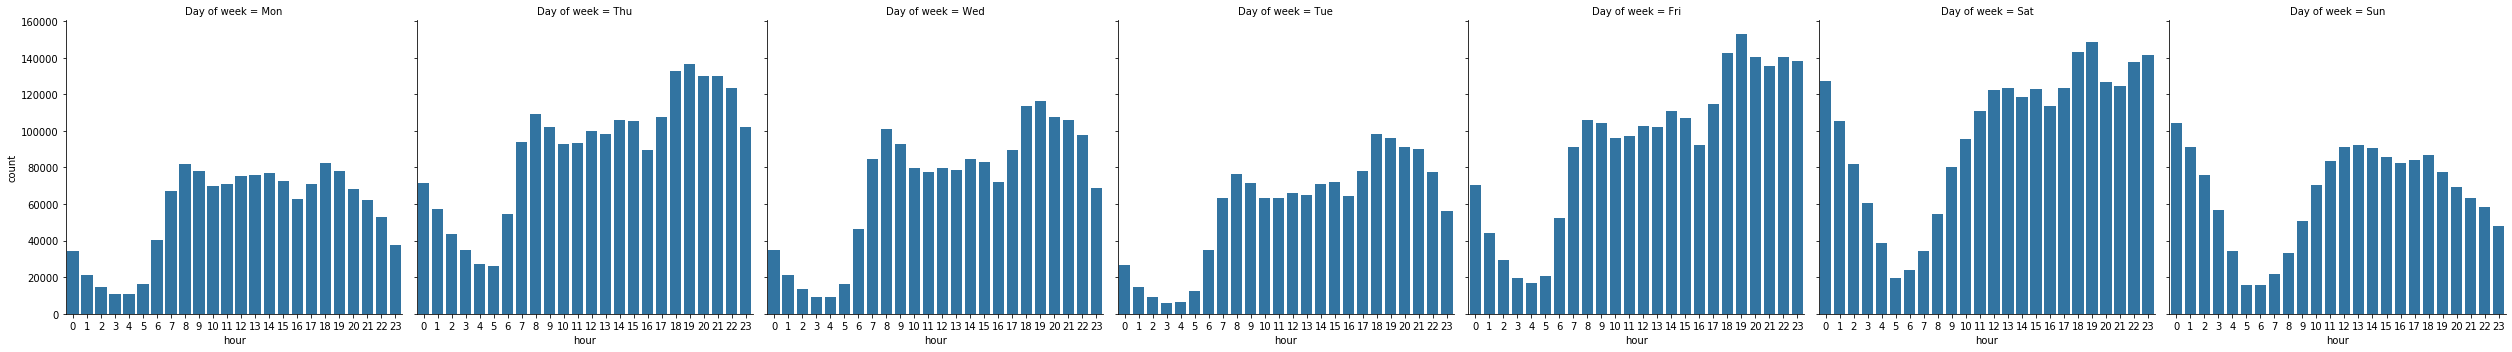

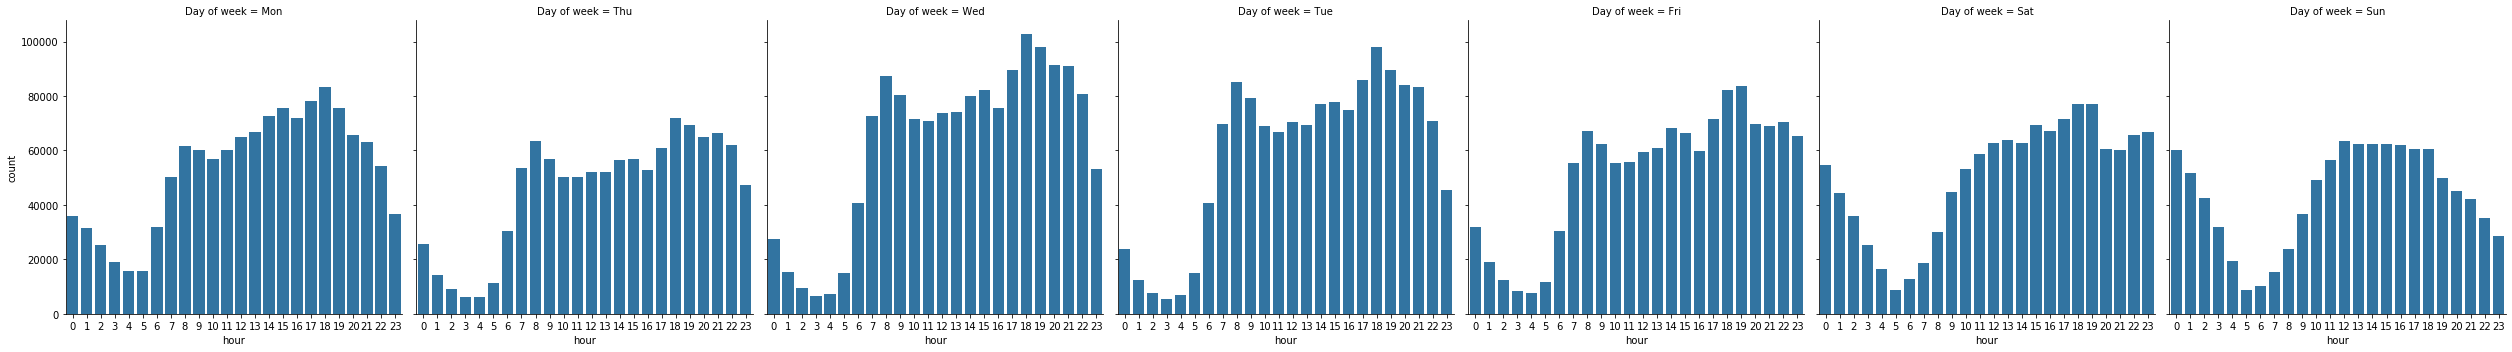

In [62]:

data = [df_2015,df_2018]
for i in range(len(data)) :
    data[i] = data[i].withColumn("Day of week", fn.date_format(data[i].tpep_pickup_datetime,'E'))


for i in range(len(data)) : 
    g = sns.FacetGrid(data = data[i].groupBy("Day of week",fn.hour("tpep_pickup_datetime").alias("hour"))\
                                .count()\
                                .orderBy("hour")\
                                .toPandas(),
                      col = "Day of week",
                      height = 5)
    g = g.map(sns.barplot, "hour","count"
                )

In [ ]:
fig, ax = plt.subplots(1,2, sharey = True, figsize = (15,7))

for i in range(len(data)) :
    sns.barplot(x = "hour",
                y = "avg(fare_amount)",
                data = data[i].groupBy(hour("tpep_pickup_datetime").alias("hour"))\
                                    .avg("fare_amount").toPandas(),
                ax = ax[i])

In [ ]:
fig, ax = plt.subplots(1,2, sharey = True, figsize = (15,7))



for i in range(len(data)) :
    data[i] = data[i].withColumn("duration",
                                 (fn.col("tpep_dropoff_datetime").cast("long") - 
                                  fn.col("tpep_pickup_datetime").cast("long"))/60)
    sns.barplot(x = "hour",
                y = "avg(duration)",
                data = data[i].groupBy(hour("tpep_pickup_datetime").alias("hour"))\
                                    .avg("duration").toPandas(),
                ax = ax[i])

In [ ]:
fig, ax = plt.subplots(1,2, sharey = True, figsize = (15,7))


for i in range(len(data)) :
    tmp = data[i].groupBy(hour("tpep_pickup_datetime").alias("hour"))\
                                .count()
    tmp = tmp.withColumn("avg", col("count")/31) #31 days in January 
    sns.barplot(x = "hour", 
                y = "avg", 
                data = tmp.toPandas(),
                ax = ax[i]
                )

## Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitude and magnitudes 
of Manhattan, you can use a service like [geojson.io](http://geojson.io/).
Plot the following time series, indexed the day of the week and hour of the day

1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport
1. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

In [ ]:
import geopandas as gpd


## Geographic information

For this, you will need to find tools to display maps and to build choropeth maps.
We let you look and find relevant tools to do this.

1. Build a heatmap where color is a function of
    1. number of `pickups`
    2. number of `dropoffs`
    3. number of `pickups` with dropoff at some airport (JFK, LaGuardia, Newark)
2. Build a choropeth map where color is a function of
    1. number of pickups in the area
    1. ratio of number of payments by card/number of cash payments for pickups in the area
    2. ratio of total fare/trip duration for dropoff in the area
3. Build an interactive chorophet with a slider allowing the user to select an `hour of day` and where the color is a function of
    1. average number of dropoffs in the area during that hour the day
    2. average ratio of tip over total fare amount for pickups in the area at given hour of the day